# One-Dimensional Climate Models: The Basics of Brown Dwarfs

In this tutorial you will learn the very basics of running 1D climate runs. For a more in depth look at the climate code check out [Mukherjee et al. 2022](https://arxiv.org/abs/2208.07836) (note this should also be cited if using this code/tutorial). 

What you should already be familiar with: 

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)

What you will need to download to use this tutorial: 

1. [Download](https://zenodo.org/record/5590989#.Yzy2YOzMI8a) 1460 PT, 196 wno Correlated-K Tables from Roxana Lupu to be used by the climate code for opacity 
2. [Download](https://zenodo.org/record/5063476/files/structures_m%2B0.0.tar.gz?download=1) the sonora bobcat cloud free `structures_` file so that you can validate your model run 

**Note**: the two files above are dependent on metallicity and C/O. For this tutorial we will stick to solar M/H and solar C/O, but note that you can change that by picking the right C-K file in the `opannection` step

In [2]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [3]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f'/Users/adityasengupta/projects/clouds/picaso/data/kcoeff_2020/sonora_2020_feh{mh}_co_{CtoO}.data.196'
#sonora bobcat cloud free structures file
sonora_profile_db = '/Users/adityasengupta/projects/clouds/picaso/data/sonora_bobcat/structures_m+0.0'


## What does a climate model solve for?

1D Radiative-Convective Equilibrium Models solve for atmospheric structures of brown dwarfs and exoplanets, which includes:

1\. The Temperature Structure (T(P) profile)
 
2\. The Chemical Structure 

3\. Energy Transport in the atmosphere

But these physical components are not independent of each other. For example, the chemistry is dependent on the T(P) profile, the radiative transfer is dependent on clouds and the chemistry and so on. 

`PICASO` tries to find the atmospheric state of your object by taking care of all of these processes and their interconnections self-consistently and iteratively. Therefore, you will find that the climate portion of `PICASO` is slower than running a single forward model evaluation. 

## Starting up the Run

You will notice that starting a run is nearly identical as running a spectrum. However, how we will add `climate=True` to our inputs flag. We will also specify `browndwarf` in this case, which will turn off the irradiation the object is receiving. 

New Parameter: **Effective Temperature**. This excerpt from [Modeling Exoplanetary Atmospheres (Fortney et al)](https://arxiv.org/pdf/1804.08149.pdf) provides a thorough description and more reading, if you are interested.

>If the effective temperature, $T_{eff}$, is defined as the temperature of a blackbody of
the same radius that would emit the equivalent flux as the real planet, $T_{eff}$ and $T_{eq}$
can be simply related. This relation requires the inclusion of a third temperature,
$T_{int}$, the intrinsic effective temperature, that describes the flux from the planet’s
interior. These temperatures are related by:"

>$T_{eff}^4 =  T_{int}^4 + T_{eq}^4$

>We then recover our limiting cases: if a planet is self-luminous (like a young giant
planet) and far from its parent star, $T_{eff} \approx  T_{int}$; for most rocky planets, or any
planets under extreme stellar irradiation, $T_{eff} \approx T_{eq}$.

In [4]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation 

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation  


teff= 1000 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

Let's now grab our gaseous opacities, whose path we have already defined above. Again, this code uses a correlated-k approach for accurately capturing opacities (see [section 2.1.4; Mukerjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf)).

In [5]:
# Notice The keyword ck is set to True because you want to use the correlated-k opacities for your calculation
# and not the line by line opacities
opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

## Initial T(P)  Guess

Every calculation requires an initial guess of the pressure temperature profile. The code will iterate from there to find the correct solution. A few tips: 

1. We recommend **using typically 51-91 atmospheric pressure levels**. Too many pressure layers increases the computational time required for convergence. Too little layers makes the atmospheric grid too coarse for an accurate calculation.

2. Start with **a guess that is close to your expected solution**. We will show an example using an isothermal P(T) profile below so you can see the iterative process. Later though, we recommend leveraging pre-computed grids (e.g. Sonora) as a starting guess for Brown Dwarfs. 


In [6]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars

Pmin = 1e-4 #bars
Pmax = 500 #bars
pressure=np.logspace(np.log10(Pmin),np.log10(Pmax),nlevel) # set your pressure grid

temp_guess = np.zeros(shape=(nlevel)) + 500 # K , isothermal atmosphere guess

## Initial Convective Zone Guess

You also need to have a crude guess of the convective zone of your atmosphere. Generally the deeper atmosphere is always convective. Again a good guess is always the published SONORA grid of models for this. But lets assume that the bottom 7 levels of the atmosphere is convective. 

**New Parameters:**

1. `nofczns` : Number of convective zones. Though the code has functionality to solve for more than one. In this basic tutorial, let's stick to 1 for now.
2. `rfacv`: (See Mukherjee et al Eqn. 20 `r_st`) https://arxiv.org/pdf/2208.07836.pdf
3. `nstr_upper` : this defines the top most level of your guessed convective zone. If you don't have a clue where your convective zone might end be choose a number that is $\sim$nlevel-5 (a few pressure levels away from the very bottom of your grid)

Non-zero values of rst (aka "rfacv" legacy terminology) is only relevant when the external irradiation on the atmosphere is non-zero. In the scenario when a user is computing a planet-wide average T(P) profile, the stellar irradiation is contributing to 50% (one hemisphere) of the planet and as a result rst = 0.5. If instead the goal is to compute a night-side average atmospheric state, rst is set to be 0. On the other extreme, to compute the day-side atmospheric state of a tidally locked planet rst should be set at 1.

In [7]:
nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 83 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

Now we would use the inputs_climate function to input everything together to our cl_run we started.

In [8]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, 
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

## Run the Climate Code

 The actual climate code can be run with the cl_run.run command. The save_all_profiles is set to True to save the T(P) profile at all steps. The code will now iterate from your guess to reach the correct atmospheric solution for your brown dwarf of interest.
 
 

In [12]:
cl_run.inputs["climate"]["cloudy"] = 1

In [13]:
import cProfile
cProfile.run("cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)")

 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
         161349 function calls (155570 primitive calls) in 0.176 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      668    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
        2    0.000    0.000    0.000    0.000 <frozen codecs>:260(__init__)
        2    0.000    0.000    0.000    0.000 <frozen codecs>:309(__init__)
        2    0.000    0.000    0.000    0.000 <frozen codecs>:319(decode)
       10    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1285(_sanity_check)
       10    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1349(_find_and_load)
       10    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1375(_gcd_import)
       22    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap

TypeError: 'int' object is not iterable

In [38]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
Big iteration is  359.329825812465 0
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
Profile converged before itmx
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
Big iteration is  359.329825812465 0
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
Profile converged before itmx
final [ 0 73 89  0 83 89]
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
 We are already at a root, tolf , test =  5e-05 ,  2.620031404170756e-05
YAY ! ENDING WITH CONVERGENCE


## Benchmark with Sonora Bobcat

Text(0.5, 1.0, 'T$_{\\rm eff}$= 1000 K, log(g)=5.0')

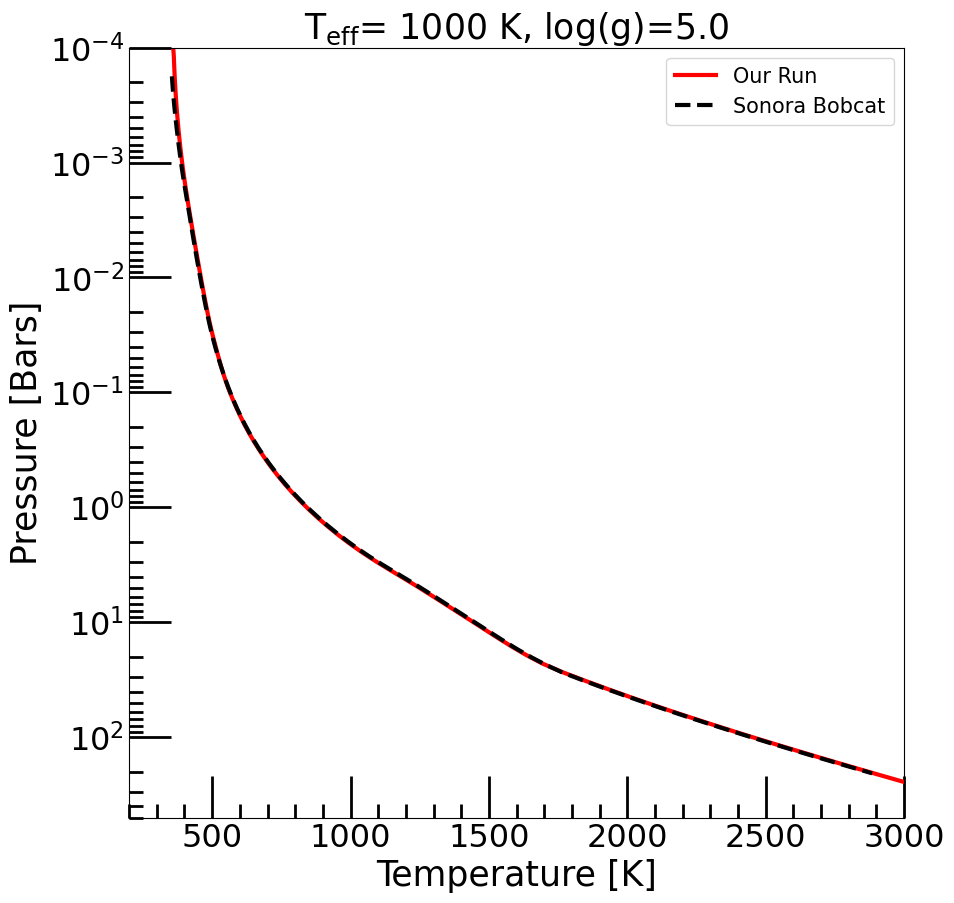

In [21]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(500,1e-4)
plt.xlim(200,3000)

plt.semilogy(out['temperature'],out['pressure'],color="r",linewidth=3,label="Our Run")

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)



## Climate Plots and Animations 

### Animate Convergence

We can also try to see how our initial guess of an isothermal atmosphere was changed by the code to reach the converged solution

In [31]:
#ani = jpi.animate_convergence(out, cl_run, opacity_ck, 
#    molecules=['H2O','CH4','CO','NH3'])

In [32]:
# ani

### Brightness Temperature

Checking the brightness temperature serves many useful purposes: 

1. Intuition building. Allows you to see what corresponding temperature are you sensitive to at each wavelength 

Note that this temperature doesn't need to be the physical temperature of your atmosphere but if you can find the physical converged atmospheric temperature closest to this brightness temperature you can also get an idea of the atmospheric pressure from where the flux you are seeing is originating from.

2. Determining if your choice in bottom boundary pressure grid was correct. 

If your brightness temperature is such that you bottom out at the temperature corresponding to the highest pressure, you have not extended your grid to high enough pressures. 

Brightness Temperature Equation:

$T_{\rm bright}=\dfrac{a}{{\lambda}log\left(\dfrac{{b}}{F(\lambda){\lambda}^5}+1\right)}$

where a = 1.43877735x$10^{-2}$ m.K and b = 11.91042952x$10^{-17}$ m$^4$kg/s$^3$ 

Let's calculate the brightness temperature of our current run and check if our pressure grid was okay.

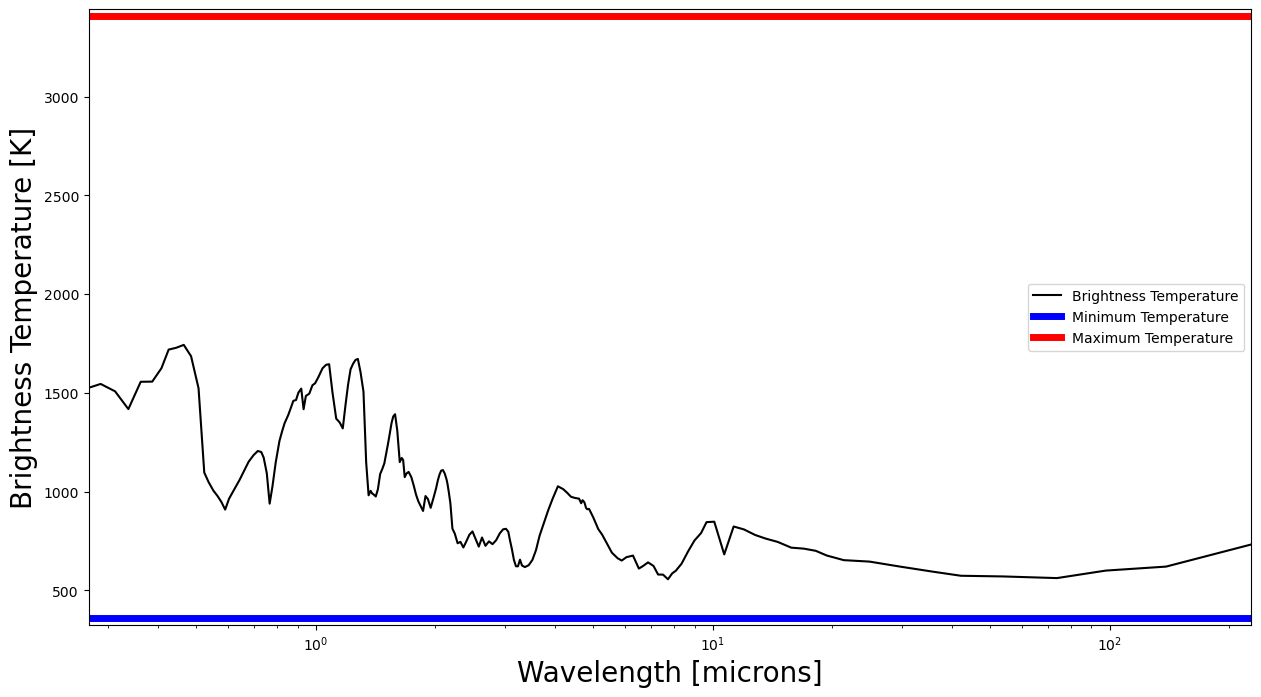

In [25]:
brightness_temp, figure= jpi.brightness_temperature(out['spectrum_output'])

In the above plot you can see that your brightness temperature is nicely bound between the minimum and maximum temperature. Your run is good and your choice of pressure grid is also great. Well done team!


## Selecting an Adequate Pressure Grid

For understanding and intuition building, let's do out a run where we purposely choose an incomplete pressure grid. Let's do the same run by the max pressure set at only 3 bars instead of 500 bars.

In [26]:
cl_bad_pres = jdi.inputs(calculation="brown", climate = True)
cl_bad_pres.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_bad_pres.effective_temp(teff)

nlevel = 91 # number of plane-parallel levels in your code
Pmin = 1e-4 #bars
Pmax = 3 #bars
pressure=np.logspace(np.log10(Pmin),np.log10(Pmax),nlevel) # set your pressure grid

temp_guess = np.zeros(shape=(nlevel)) + 500 # K , isothermal atmosphere guess

nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 83 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

cl_bad_pres.inputs_climate(temp_guess= temp_guess, pressure= pressure, 
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)
out_bad_pres = cl_bad_pres.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  499.0007446148345 659.9082314337127 , flux balance  -0.8868736488996584
Iteration number  1 , min , max temp  491.39439008611214 827.8189365805938 , flux balance  -0.7568053342450737
Iteration number  2 , min , max temp  484.38931490602124 890.4016296529816 , flux balance  -0.6695079923314208
Iteration number  3 , min , max temp  477.6387042489422 929.8740353151015 , flux balance  -0.5964371783054667
Iteration number  4 , min , max temp  460.03853724930235 1005.358303666465 , flux balance  -0.39861197916494717
Iteration number  5 , min , max temp  401.6117604620177 1122.4623577501218 , flux balance  0.17810931923212572
Iteration number  6 , min , max temp  381.0442303672093 1098.3420771197498 , flux balance  0.01977187579197599
Iteration number  7 , min , max temp  378.0003119909761 1095.201598668658 , flux balance  0.0009352217381814661
Iteration number  8 , min , max temp  377.8831621385691 1095.0486709104835 , flux balance  3.562133579892645e-05

Lets plot the profile from our new run and check it against our old run.

Text(0.5, 1.0, 'T$_{\\rm eff}$= 1000 K, log(g)=5.0')

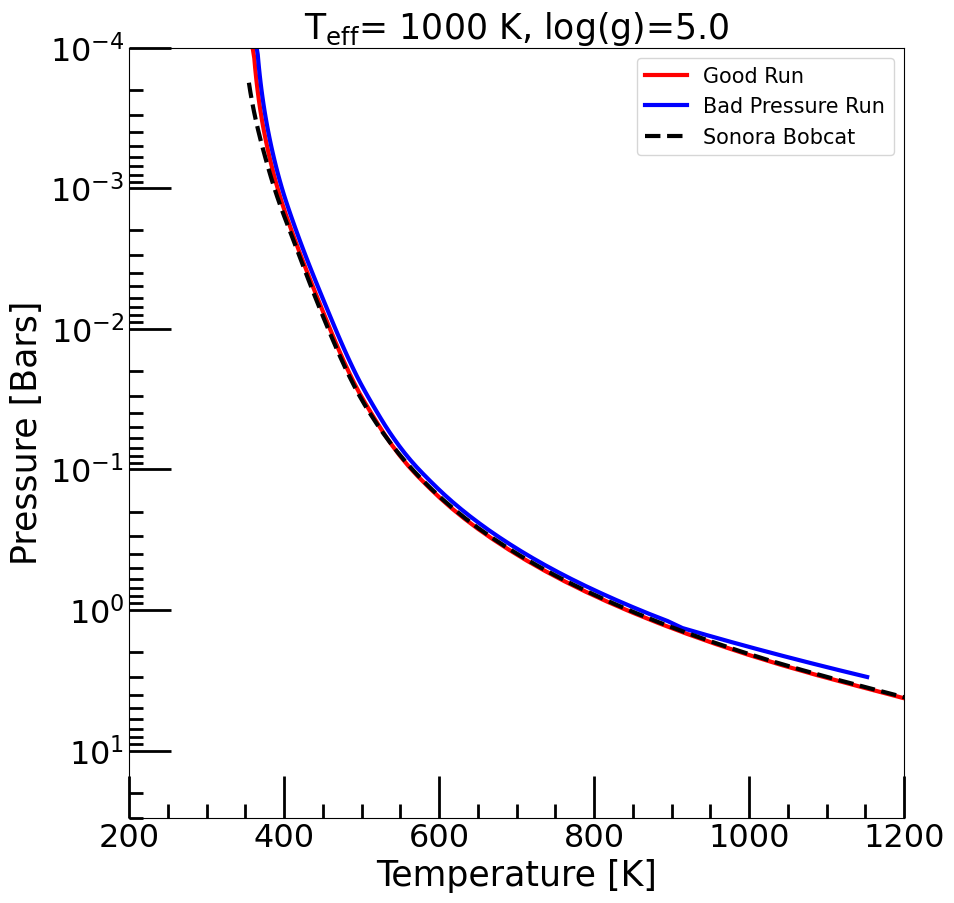

In [27]:
plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(30,1e-4)
plt.xlim(200,1200)

plt.semilogy(out['temperature'],out['pressure'],color="r",linewidth=3,label="Good Run")
plt.semilogy(out_bad_pres['temperature'],out_bad_pres['pressure'],color="b",linewidth=3,label="Bad Pressure Run")

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)



This new profile is slightly off from our run and also the sonora bobcat run. Lets look at its brightness temperature as a function of wavelength and check if it matches well with our previous run.

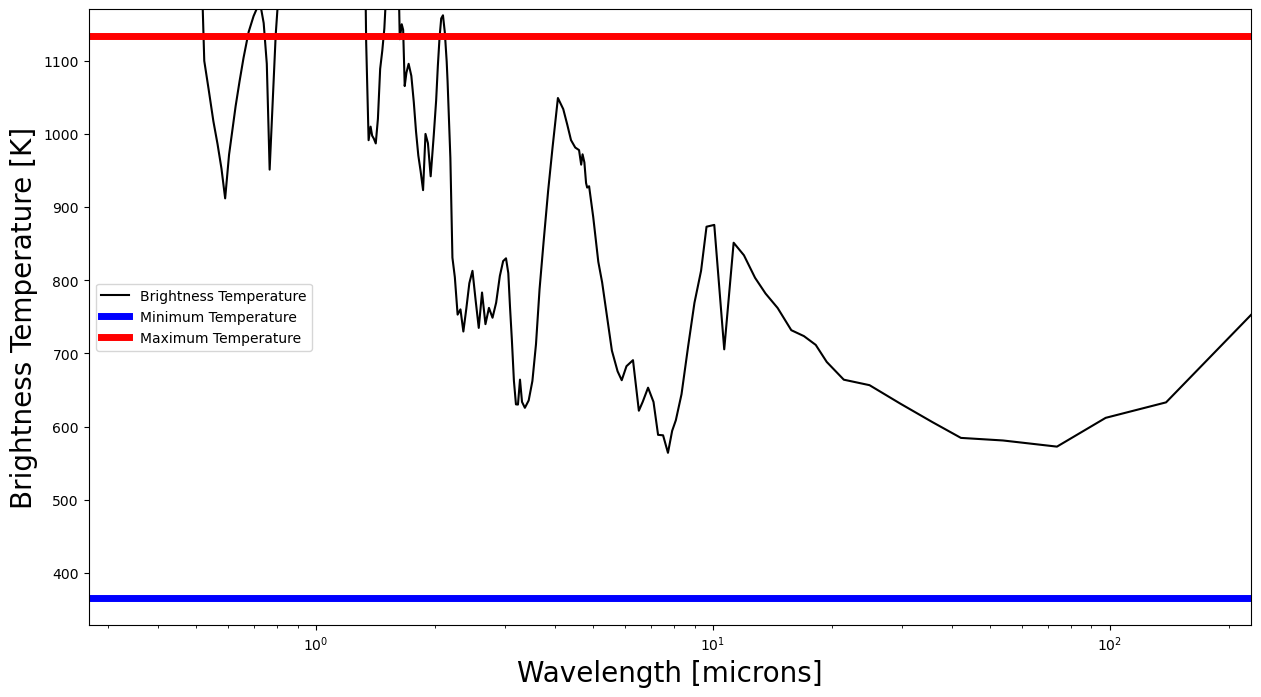

In [28]:
brightness_temp_bad, figure_bad= jpi.brightness_temperature(
    out_bad_pres['spectrum_output'])

See how the brightness temperature from this new run is different from our previous succesful run. The brightness temperatures infact goes over the maximum temperature achieved by the model. Therefore the pressure grid used for this run is incorrect because one can look through the atmosphere to the bottom of the grid at most wavelengths which is not good and the resultant "converged" T(P) profile is also visibly inaccurate as a result as well.

## Post Process High Resolution Spectrum
We can quickly do this by resetting the opannection to not use the ck database and use the `ptchem_df` DataFrame as input for the atmosphere 

This is also the point where you could post-process clouds using `virga` or a `box model` as seen in these tutorials here: 
1. [Adding clouds with virga](https://natashabatalha.github.io/picaso/notebooks/7_PairingPICASOToVIRGA.html) 
2. [Adding box model clouds](https://natashabatalha.github.io/picaso/notebooks/5_AddingTransitSpectrum.html#Adding-Grey-Cloud) 

In [29]:
opa_mon = jdi.opannection()

hi_res = jdi.inputs(calculation="browndwarf") # start a calculation 
teff= 1000 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

hi_res.atmosphere(df=out['ptchem_df']) 
df_spec = hi_res.spectrum(opa_mon, calculation='thermal')
w,f = jdi.mean_regrid(df_spec['wavenumber'],df_spec['thermal'], R=100)

In [30]:
jpi.show(jpi.spectrum(w,f,x_axis_type='log',y_axis_type='log'))